# SimVP Implementation

## 0. Setting

In [1]:
# Library Call
from API import *
import utils, visualization
import model, modules, exp, main

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torch.utils.data import TensorDataset, DataLoader
import tqdm

model_dir = 'model'
tensorboard_dir = 'tensorboard'
data_dir = '/home/jpark/data/'

utils.set_seed(1123)

In [ ]:
# # Tensorflow CUDA Connection
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [32]:
# Pytorch CUDA Connection
print('Available :',torch.cuda.is_available())
print('Current device :',torch.cuda.current_device())
print('Usuable device :',torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda = torch.device('cuda')


Available : True
Current device : 0
Usuable device : 1
NVIDIA GeForce RTX 2080 Ti


## 1. Data Load & Preprocessing

In [9]:
mmnist = dataload.load_data(data_dir, 'mmnist')

(samples, frames, w, h, c) : (10000, 20, 64, 64, 1)


In [10]:
mmnist = np.swapaxes(mmnist,2,4)
print(mmnist.shape)

(10000, 20, 1, 64, 64)


In [11]:
# Split into train & valid & test sets using indexing to optimize memory.
indexes = np.arange(mmnist.shape[0])
np.random.shuffle(indexes)

# train : valid : test = 8 : 1 : 1
sep = int(0.8 * mmnist.shape[0])
train_index = indexes[: sep]
val_index = indexes[sep : sep+1000] 
test_index = indexes[sep+1000 :]
train_dataset = mmnist[train_index]
val_dataset = mmnist[val_index]
test_dataset = mmnist[test_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255
test_dataset = test_dataset / 255

print('train_dataset.shape :',train_dataset.shape)
print('val_dataset.shape :',val_dataset.shape)
print('test_dataset.shape :',test_dataset.shape)

train_dataset.shape : (8000, 20, 1, 64, 64)
val_dataset.shape : (1000, 20, 1, 64, 64)
test_dataset.shape : (1000, 20, 1, 64, 64)


In [12]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data, input_num, output_num):
    x = data[:, 0 : input_num , :, :]
    y = data[:, input_num : input_num + output_num, :, :]
    return x, y

In [13]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset, 10, 10)
x_val, y_val = create_shifted_frames(val_dataset, 10, 10)
x_test, y_test = create_shifted_frames(test_dataset, 10, 10)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Test Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (8000, 10, 1, 64, 64), (8000, 10, 1, 64, 64)
Validation Dataset Shapes: (1000, 10, 1, 64, 64), (1000, 10, 1, 64, 64)
Test Dataset Shapes: (1000, 10, 1, 64, 64), (1000, 10, 1, 64, 64)


In [14]:
from torch.utils.data import Dataset
class customdataset(Dataset):
    def __init__(self,x,y):
        self.x_data = x
        self.y_data = y
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x_out = torch.FloatTensor(self.x_data[idx])
        y_out = torch.FloatTensor(self.y_data[idx])
        return x_out, y_out

In [15]:
train_tensor = customdataset(x_train, y_train)
valid_tensor = customdataset(x_val, y_val)
test_tensor = customdataset(x_test, y_test)

In [34]:
train_dataloader = DataLoader(train_tensor, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_tensor, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_tensor, batch_size=16, shuffle=False)

## Data Visualization

Displaying frames for example 3656.


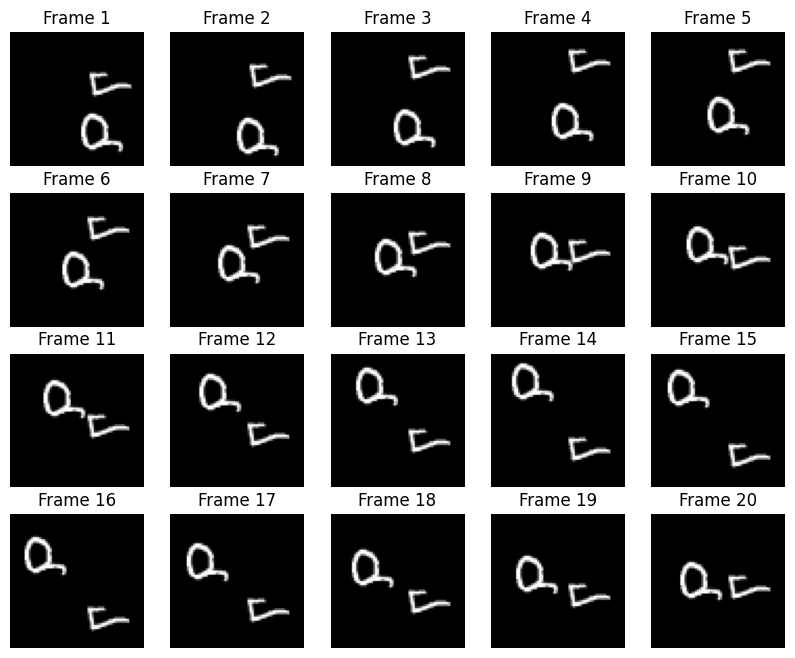

In [17]:
utils.set_seed(1123)
visualization.multi_frame_visualize(train_dataset)

In [18]:
video = visualization.create_videos(train_dataset)

In [19]:
visualization.display_video(video)

 Truth	Prediction


## SimVP Model Construction

In [20]:
model = model.SimVP(x_train.shape[1:]).cuda()

In [21]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

In [ ]:
for epoch in range(50):
    train_loss = []
    model.train()
    train_pbar = tqdm.tqdm(train_dataloader)

    for batch_x, batch_y in train_pbar:
        optimizer.zero_grad()
        batch_x, batch_y = batch_x.to(cuda), batch_y.to(cuda)
        pred_y = model(batch_x)

        loss = criterion(pred_y, batch_y)
        train_loss.append(loss.item())
        train_pbar.set_description('train loss: {:.4f}'.format(loss.item()))

        loss.backward()

    train_loss = np.average(train_loss)

In [31]:
batch_x.shape

torch.Size([16, 10, 1, 64, 64])

In [24]:
loss = loss.item()
print(f"loss: {loss}")

loss: 0.7789510488510132


In [ ]:
model.eval()
inputs_lst, trues_lst, preds_lst = [], [], []
for batch_x, batch_y in test_dataloader:
    pred_y = model(batch_x.to(cuda))
    list(map(lambda data, lst: lst.append(data.detach().cpu().numpy()), [
                 batch_x, batch_y, pred_y], [inputs_lst, trues_lst, preds_lst]))

In [ ]:
a = []
b = []
for batch_x, batch_y in test_dataloader:
    pred_y = model(batch_x.to(cuda))
    a.append(pred_y)
    b.append(batch_y)
